In [1]:
!pip install pybullet

In [0]:
import gym
import math
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pybullet_envs
import random

In [18]:
ENV_ID = "MinitaurBulletEnv-v0"
#RENDER = True
#spec = gym.envs.registry.spec(ENV_ID)
env = gym.make(ENV_ID)

urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data
options= 


In [0]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [0]:
class Actor(nn.Module):
  def __init__(self, input_shape, output_shape):
    super(Actor, self).__init__()
    
    self.network = nn.Sequential(nn.Linear(input_shape, 400),
                                nn.ReLU(),
                                nn.Linear(400,300),
                                nn.ReLU(),
                                nn.Linear(300, output_shape),
                                nn.Tanh())
  def forward(self,x):
    return self.network(x)
  
class Critic(nn.Module):
  def __init__(self, input_shape, action_shape ):
    super(Critic, self).__init__()
    
    self.observation = nn.Sequential(nn.Linear(input_shape, 400),
                                nn.ReLU())
    
    self.critic = nn.Sequential(nn.Linear(400+action_shape,300),
                               nn.ReLU(),
                               nn.Linear(300, 1)
                               )

  def forward(self,x,a):
    x = self.observation(x)
    
    inputs_ = torch.cat((x,a),dim = 1)
    #print(inputs_.shape)
    q_val = self.critic(inputs_)
    return q_val

In [0]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)
    
#https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py

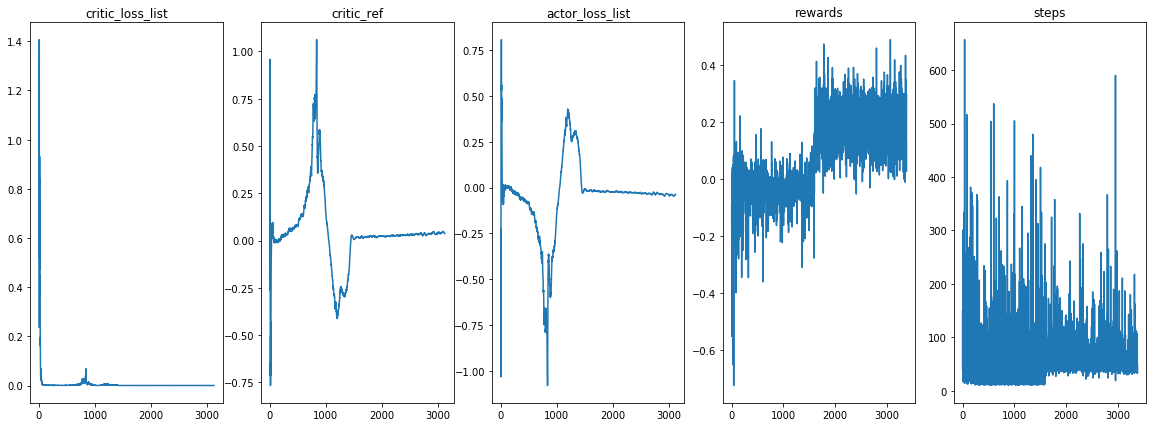

In [74]:
# init _networks etc
BATCHSIZE = 64
MEMORY = 1000000
GAMMA = 0.99
soft_tau = 1e-2
input_shape = env.observation_space.shape[0]
output_shape = env.action_space.shape[0]


actor_net = Actor(input_shape, output_shape)
target_actor = actor_net

critic_net = Critic(input_shape, output_shape)
target_critic = critic_net

actor_optim = optim.Adam(actor_net.parameters(),lr = 0.0001)
critic_optim = optim.Adam(critic_net.parameters(),lr = 0.001)

agent = OUNoise(env.action_space)

step_rate = 64

buffer = ReplayBuffer(MEMORY)


critic_loss_list = []
critic_ref = []
actor_loss_list = []
epoch_reward_list = []
epoch_rewards = 0

steps_list = []
steps = 0
frame_idx = 0
max_frames = 200000

state = env.reset()
while frame_idx < max_frames:
  agent.reset()
  
  
  for frame in range(step_rate):
    state_v = torch.FloatTensor(state)
    mu_v = actor_net(state_v)
    mu_v = agent.get_action(mu_v.detach().numpy(), frame)
    new_state, reward, done, _ = env.step(mu_v)
    buffer.push(state_v,torch.FloatTensor(mu_v), torch.FloatTensor([reward]).unsqueeze(1),torch.FloatTensor(new_state), torch.FloatTensor([done]).unsqueeze(1))
    epoch_rewards += reward
    state = new_state
    
    steps += 1
    frame_idx += 1
    
    if done == True:
      epoch_reward_list.append(epoch_rewards)
      steps_list.append(steps)
      epoch_rewards = 0
      steps = 0
      env.reset()
  
  #run_optimization
  
  states_v, actions_v, rewards_v, next_states_v, dones_v = buffer.sample(BATCHSIZE)
  
  # train critic
  critic_optim.zero_grad()
  actions_v = torch.FloatTensor(actions_v)
  next_states_v = torch.FloatTensor(next_states_v)
  states_v = torch.FloatTensor(states_v)
  rewards_v = torch.FloatTensor(rewards_v)
  
  q_v = critic_net(next_states_v, actions_v)
  last_act_v  = target_actor(states_v)
  q_last_v = target_critic(states_v, last_act_v)
  
  q_last_v[dones_v] = 0.0
  
  q_ref_v = rewards_v + q_last_v * GAMMA
  critic_loss_v = F.mse_loss(q_v, q_ref_v.detach())
  critic_loss_v.backward()
  critic_optim.step()
  critic_loss_list.append(critic_loss_v.mean().item())
  critic_ref.append(q_ref_v.mean().item())
  
  # train actor 
  actor_optim.zero_grad()
  cur_actions_v = actor_net(next_states_v)
  actor_loss_v = -critic_net(next_states_v, cur_actions_v).mean()
  actor_loss_v.backward()
  actor_optim.step()
  
  actor_loss_list.append(actor_loss_v.item())
  
  #update target_networks
  for target_param, param in zip(target_critic.parameters(), critic_net.parameters()):
    target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

  for target_param, param in zip(target_actor.parameters(), actor_net.parameters()):
    target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

# PLOTTING RESULTS

plt.figure(figsize = (20,7))
plt.subplot(1,5,1)
plt.title("critic_loss_list")
plt.plot(critic_loss_list)
plt.subplot(1,5,2)
plt.title("critic_ref")
plt.plot(critic_ref)
plt.subplot(1,5,3)
plt.title("actor_loss_list")
plt.plot(actor_loss_list)
plt.subplot(1,5,4)
plt.title("rewards")
plt.plot(epoch_reward_list)
plt.subplot(1,5,5)
plt.title("steps")
plt.plot(steps_list)

torch.Size([32, 408])